# Vision Transformers (ViT) Walkthrough

In [1]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=04240a7f787863bf2810a1e27a47d9f0965c3aa20ea47e64eff119c6387b2c59
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


In [4]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [6]:
data_flag = 'bloodmnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [ ]:
# from torchvision.transforms.transforms import Resize
# import torchvision.transforms as transforms

# # preprocessing
# train_transform = transforms.Compose([
#     transforms.Resize(224),
#     transforms.Lambda(lambda image: image.convert('RGB')),
#     transforms.AugMix(),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[.5], std=[.5])
# ])
# test_transform = transforms.Compose([
#     transforms.Resize(224),
#     transforms.Lambda(lambda image: image.convert('RGB')),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[.5], std=[.5])
# ])

# # load the data
# train_dataset = DataClass(split='train', transform=train_transform, download=download)
# test_dataset = DataClass(split='test', transform=test_transform, download=download)

# # pil_dataset = DataClass(split='train', download=download)

# # encapsulate data into dataloader form
# train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
# test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

In [ ]:
# data, labels = next(iter(train_loader))
# print(data, labels)

In [ ]:
# print(train_dataset)
# print("===================")
# print(test_dataset)

In [4]:
!pip install datasets transformers torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.5 MB/s eta 0:00:00


Let's start by downloading the CIFAR-10 dataset from HuggingFace. We will first download the training dataset by setting ```split = 'train'```, and the testing dataset after by setting ```split = 'test'```.

In [7]:
# import CIFAR-10 dataset from HuggingFace
from datasets import load_dataset


dataset_train = load_dataset(
    'albertvillanova/medmnist-v2', 'bloodmnist',
    split='train',
    download_mode='force_redownload',  # Force redownload to ensure all files are retrieved
)


dataset_train

Generating train split:   0%|          | 0/11959 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1712 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3421 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 11959
})

In [8]:
dataset_test = load_dataset(
    'albertvillanova/medmnist-v2', 'bloodmnist',
    split='test',
    download_mode='force_redownload',  # Force redownload to ensure all files are retrieved
)

dataset_test

Generating train split:   0%|          | 0/11959 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1712 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3421 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 3421
})

In [9]:
# check how many labels/number of classes
num_classes = len(set(dataset_train['label']))
labels = dataset_train.features['label']
num_classes, labels

(8,
 ClassLabel(names=['basophil', 'eosinophil', 'erythroblast', 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet'], id=None))

*Training*: 50,000 images divided into 10 classes

*Test*: 10,000 images divided into 10 classes

In [13]:
dataset_train[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=28x28>,
 'label': 7}

Those are PIL images with $3$ color channels, and $32x32$ pixels resolution. Let's have a look at the first picture in the dataset.

In [15]:
dataset_train[0]['image']

In [16]:
dataset_train[0]['label'], labels.names[dataset_train[0]['label']]

(7, 'platelet')

### Loading ViT Feature Extractor

We use `google/vit-base-patch16-224-in21k` model from the Hugging Face Hub.

The model is named as so as it refers to base-sized architecture with patch resolution of 16x16 and fine-tuning resolution of 224x224.  

In [11]:
from transformers import ViTFeatureExtractor

# import model
model_id = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(
    model_id,
)


You can see the feature extractor configuration by printing it

If we consider the first image, i.e., the airplane shown above, we can see the resulting tensor after passing the image through the feature extractor.

In [19]:
example = feature_extractor(
    dataset_train[0]['image'],
    return_tensors='pt'
)
example

{'pixel_values': tensor([[[[0.9608, 0.9608, 0.9608,  ..., 1.0000, 1.0000, 1.0000],
          [0.9608, 0.9608, 0.9608,  ..., 1.0000, 1.0000, 1.0000],
          [0.9608, 0.9608, 0.9608,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.7020, 0.7020, 0.7020,  ..., 1.0000, 1.0000, 1.0000],
          [0.7020, 0.7020, 0.7020,  ..., 1.0000, 1.0000, 1.0000],
          [0.7020, 0.7020, 0.7020,  ..., 1.0000, 1.0000, 1.0000]],

         [[0.7490, 0.7490, 0.7490,  ..., 0.8353, 0.8353, 0.8353],
          [0.7490, 0.7490, 0.7490,  ..., 0.8353, 0.8353, 0.8353],
          [0.7490, 0.7490, 0.7490,  ..., 0.8353, 0.8353, 0.8353],
          ...,
          [0.4275, 0.4275, 0.4275,  ..., 0.7882, 0.7882, 0.7882],
          [0.4275, 0.4275, 0.4275,  ..., 0.7882, 0.7882, 0.7882],
          [0.4275, 0.4275, 0.4275,  ..., 0.7882, 0.7882, 0.7882]],

         [[0.6157, 0.6157, 0.6157,  ..., 0.4980, 0.4980, 0.4980],
          [0.6157, 0.6157, 0.6157,  ..., 0.4980, 0.4980, 0.4980],
          [0.6157, 0.6157

In [20]:
example['pixel_values'].shape

torch.Size([1, 3, 224, 224])

In [12]:
# load in relevant libraries, and alias where appropriate
import torch

# device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [13]:
def preprocess(batch):
    # take a list of PIL images and turn them to pixel values
    inputs = feature_extractor(
        batch['image'],
        return_tensors='pt'
    )
    # include the labels
    inputs['label'] = batch['label']
    return inputs

We can apply this to both the training and testing dataset.

In [ ]:
# data_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[.5], std=[.5]),
# ])

# # transformation for converting to PIL without normalization
# to_pil_transform = transforms.Compose([
#     transforms.ToPILImage(),
# ])

# def preprocess1(batch):
#     inputs = feature_extractor(
#         batch,
#         return_tensors='pt'
#     )
#     # convert to PIL without normalization
#     inputs['image'] = to_pil_transform(inputs['image'].squeeze(0))
#     # include the labels
#     inputs['label'] = batch['label']
#     return inputs

In [14]:
# transform the training dataset
prepared_train = dataset_train.with_transform(preprocess)
# ... and the testing dataset
prepared_test = dataset_test.with_transform(preprocess)

Now, whenever you get an example from the dataset, the transform will be applied in real time (on both samples and slices).

### Model Fine-Tuning

In this section, we are going to build the Trainer, which is a feature-complete training and eval loop for PyTorch, optimized for HuggingFace 🤗 Transformers.

We need to define all of the arguments that it will include:
* training and testing dataset
* feature extractor
* model
* collate function
* evaluation metric
* ... other training arguments.

The collate function is useful when dealing with lots of data. Batches are lists of dictionaries, so collate will help us create batch tensors.

In [15]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

Let's now define the evaluation metric we are going to use to compare prediction with actual labels. We will use the *accuracy evaluation metric*.

Accuracy is defined as the proportion of correct predictions (True Positive ($TP$) and True Negative ($TN$)) among the total number of cases processed ($TP$, $TN$, False Positive ($FP$), and False Negative ($FN$)).

$$Accuracy = \frac{(TP + TN)}{(TP + TN + FP + FN)}$$    

Below, we are using accuracy within the ```compute_metrics``` function.

In [16]:
import numpy as np
from datasets import load_metric

# accuracy metric
metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(
        predictions=np.argmax(p.predictions, axis=1),
        references=p.label_ids
    )

<ipython-input-16-b7bbca42f0bd>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


The last thing consists of defining ```TrainingArguments```.

Most of these are pretty self-explanatory, but one that is quite important here is ```remove_unused_columns=False```. This one will drop any features not used by the model's call function. By default it's True because usually it's ideal to drop unused feature columns, making it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('image' in particular) in order to create 'pixel_values'.

We have chosen a batch size equal to 16, 100 evaluation steps, and a learning rate of $2e^{-4}$.

In [ ]:
! pip install -U accelerate
! pip install -U transformers

In [17]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./medmnist",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  load_best_model_at_end=True,
)

We can now load the pre-trained model. We'll add ```num_labels``` on init so the model creates a classification head with the right number of units.

In [18]:
from transformers import ViTForImageClassification

# labels = dataset_train.features['label'].names

model = ViTForImageClassification.from_pretrained(
    model_id,  # classification head
    num_labels=n_classes)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

We can see the characteristics of our model.

Now, all instances can be passed to ```Trainer```.

In [20]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_train,
    eval_dataset=prepared_test,
    tokenizer=feature_extractor,
)

We can save our trained model.

In [21]:
train_results = trainer.train()
# save tokenizer with the model
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
# save the trainer state
trainer.save_state()

Step,Training Loss,Validation Loss,Accuracy
100,0.471300,0.561416,0.825490
200,0.406200,0.569057,0.828705
300,0.292000,0.356068,0.892429
400,0.295600,0.291398,0.892137
500,0.287300,0.260910,0.921660
600,0.233100,0.303370,0.900614
700,0.228400,0.280430,0.912891
800,0.151800,0.188777,0.942122
900,0.182800,0.133108,0.959369
1000,0.227300,0.160963,0.952061


***** train metrics *****
  epoch                    =          4.0
  total_flos               = 3452511651GF
  train_loss               =       0.1555
  train_runtime            =   1:04:33.07
  train_samples_per_second =       12.351
  train_steps_per_second   =        0.773


#### Model Evaluation

We can now evaluate our model using the accuracy metric defined above...

In [22]:
metrics = trainer.evaluate(prepared_test)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9769
  eval_loss               =     0.0858
  eval_runtime            = 0:00:57.40
  eval_samples_per_second =     59.592
  eval_steps_per_second   =      7.456


Model accuracy is pretty good. Let's have a look to an example. We can pick the first image in our testing dataset and see if the predicted label is correct.

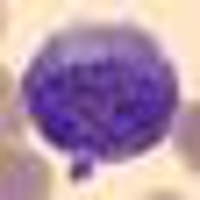

In [24]:
# show the first image of the testing dataset
image = dataset_test["image"][0].resize((200,200))
image

The image is not very clear, even when resized. Let's extract the actual label.

In [25]:
# extract the actual label of the first image of the testing dataset
actual_label = dataset_test["label"][0]

labels = dataset_test.features['label']
actual_label, labels.names[actual_label]


(3, 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)')

It looks like the image represents a cat. Let's now see what our model has predicted. Given we saved it on the HuggingFace Hub, we first need to import it. We can use ViTForImageClassification and ViTFeatureExtractor to import the model and extract its features. We would need the predicted pixel values "pt".

In [27]:
from transformers import ViTForImageClassification, ViTFeatureExtractor

# import our fine-tuned model
model_name_or_path = '/content/medmnist'
model_finetuned = ViTForImageClassification.from_pretrained(model_name_or_path)
# import features
feature_extractor_finetuned = ViTFeatureExtractor.from_pretrained(model_name_or_path)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [28]:
inputs = feature_extractor_finetuned(image, return_tensors="pt")

with torch.no_grad():
    logits = model_finetuned(**inputs).logits

We can now see what is our predicted label. Do extract it, we can use the argmax function.

In [29]:
predicted_label = logits.argmax(-1).item()
labels = dataset_test.features['label']
labels.names[predicted_label]

'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)'

And the answer is cat. Which is what we would expect.

## References

[Article](https://pinecone.io/learn/vision-transformers/)

[1] Dosovitskiy et al., [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929), 2021, CV.

[2] Vaswani et al., [Attention Is All You Need](https://arxiv.org/abs/1706.03762), 2017.

[3] Saeed M., [A Gentle Introduction to Positional Encoding in Transformer Models, Part 1](https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/), 2022, Attention, Machine Learning Mastery.